In [2]:
rm(list=ls())
library(dplyr)
library(tidyr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [3]:
exposure_name="NumberDaysWalked10Minutes"
outcome_name="CvdStatus"

In [4]:
#load the covariates 
covar=read.table("mr_covariates.euro.txt",header=TRUE,sep='\t',stringsAsFactors = FALSE)
covar$IID=NULL
covar$Sex=factor(covar$Sex)
covar$f.batch=NULL


icd=read.table("primary_cause_of_death_collapsed.txt",header=TRUE,sep='\t',stringsAsFactors = FALSE)
icd$IID=NULL
icd$UnderlyingPrimaryCauseOfDeath=factor(icd$UnderlyingPrimaryCauseOfDeath)
#add in column for major cause of death 
data=inner_join(covar,icd,by="FID")


In [5]:
# add in age^2 as a covariate 
ages=read.table("ages_recruitment_death.txt",header=TRUE,sep='\t',stringsAsFactors = FALSE)
ages$AgeSquared=ages$AgeAtRecruitment^2

In [6]:
#calculate time to death
ages$time_to_death=ages$AgeAtDeath-ages$AgeAtRecruitment

#or, other outcome: 
#outcome_mr=read.table("mr_outcome.txt",header=TRUE,row.names=1,sep='\t')
#outcome_v=factor(as.matrix(subset(outcome_mr,select=c(outcome_name))))
data=inner_join(data,ages,by="FID")


In [7]:
#read in the PLINK results for the exposure variable 
snps=read.table(paste("mr_snp_subsets/",exposure_name,sep=""),header=TRUE,sep='\t')
snps[snps==-1]=NA
names(snps)[1]="FID"

In [8]:
#get exposure values 
exposure_mr=read.table("mr_exposures.txt",header=TRUE,sep='\t')
names(exposure_mr)[1]="FID"
exposure_mr=subset(exposure_mr,select=c("FID",exposure_name))

In [9]:
data=inner_join(data,snps,by="FID")

In [10]:
data=inner_join(data,exposure_mr,by="FID")

In [11]:
#Clean up (remove fields not needed for Cox regression)
data$IID=NULL 
data$YearOfBirth=NULL
data$AgeAtDeath=NULL
data$FID=NULL

In [12]:
#censor the subjects who are still alive 
data$status=1 
data$status[is.na(data$time_to_death)]=0

In [13]:
head(data)

Sex,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,⋯,rs6943559,rs12536518,rs12353066,rs73648077,rs9775852,rs10977008,rs7872452,rs113187443,NumberDaysWalked10Minutes,status
0,0.000098641,8.37416e-05,-0.00117254,0.000546942,0.001284070,0.002849690,0.000991806,0.001610640,2.94963e-04,⋯,0,0,0,0,NA,0,0,2,3,0
1,0.000165284,-1.74393e-03,-0.00128201,-0.001167590,0.000114421,-0.000426776,-0.000514346,0.000754035,7.04738e-04,⋯,0,0,0,0,2,0,0,1,3,0
1,-0.001150320,2.59310e-03,-0.00102302,0.001088750,0.000652283,0.001128640,0.000320505,0.001577040,-3.62959e-03,⋯,0,0,0,0,NA,0,0,1,4,0
1,-0.000301001,-4.84239e-04,0.00105944,-0.002191060,0.001082250,-0.001773900,-0.001607440,-0.001415470,9.47541e-04,⋯,0,0,0,0,1,0,0,1,7,0
1,-0.001632870,-4.77821e-04,0.00103906,0.001274720,-0.002076400,-0.001697290,0.001353240,-0.001149060,2.41438e-05,⋯,0,0,0,0,0,0,0,1,5,0
0,0.002497990,-2.32333e-04,-0.00137302,0.000604198,-0.001654240,-0.000346408,0.001155690,-0.001111370,1.74310e-03,⋯,0,0,0,1,NA,0,0,0,4,0


In [14]:
#Perform multivariate Cox Regression

#load the necessary packages 
library(survival)
library(ranger)
library(ggplot2)
library(ggfortify)


In [16]:
#fit Cox proportional hazards model that makes use of all covariates in dataset 
cox <- coxph(Surv(time_to_death, status) ~ Sex+
             PC1+
             PC2+
             PC3+
             PC4+
             PC5+
             PC6+
             PC7+
             PC8+
             PC9+
             PC10+
             UnderlyingPrimaryCauseOfDeath+
             AgeAtRecruitment+
             AgeSquared+
             NumberDaysWalked10Minutes,
             data = data)


In [17]:
summary(cox)

Call:
coxph(formula = Surv(time_to_death, status) ~ Sex + PC1 + PC2 + 
    PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + UnderlyingPrimaryCauseOfDeath + 
    AgeAtRecruitment + AgeSquared + NumberDaysWalked10Minutes, 
    data = data)

  n= 12665, number of events= 12665 
   (425674 observations deleted due to missingness)

                                     coef  exp(coef)   se(coef)      z Pr(>|z|)
Sex1                            3.119e-02  1.032e+00  1.855e-02  1.682 0.092604
PC1                             8.719e-01  2.392e+00  6.056e+00  0.144 0.885511
PC2                             1.001e+00  2.721e+00  6.037e+00  0.166 0.868307
PC3                             2.982e+00  1.972e+01  6.089e+00  0.490 0.624353
PC4                             1.262e+01  3.015e+05  6.075e+00  2.077 0.037829
PC5                             1.075e+01  4.665e+04  5.990e+00  1.795 0.072717
PC6                             4.757e+00  1.164e+02  6.040e+00  0.788 0.430946
PC7                            

In [18]:
cox_fit <- survfit(cox)


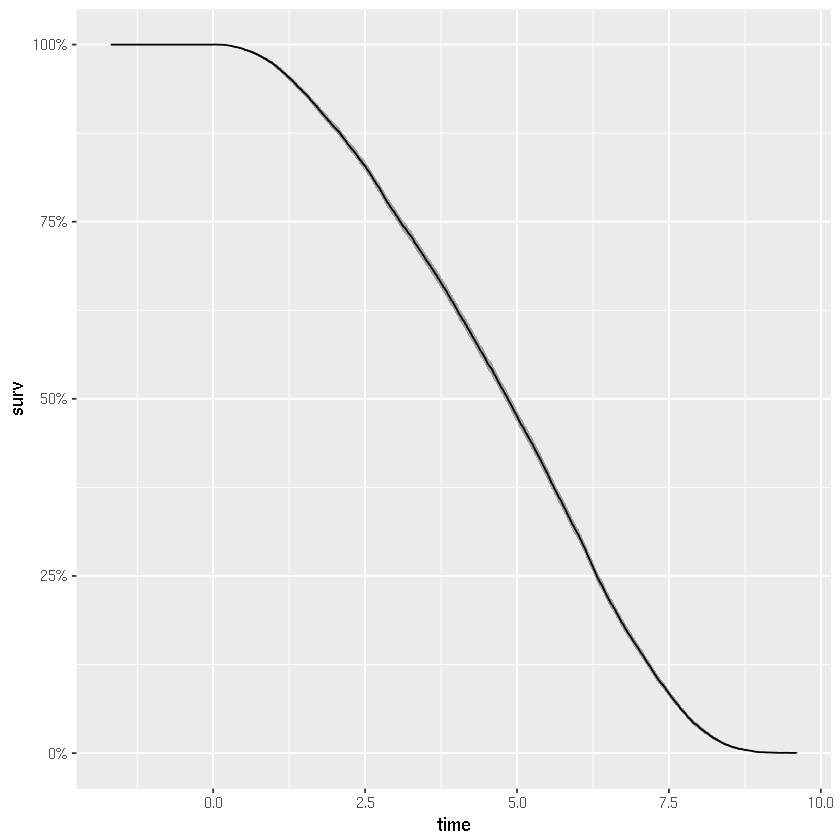

In [19]:
autoplot(cox_fit)


In [22]:
aa_fit <- aareg(Surv(time_to_death, status) ~ Sex+
             PC1+
             PC2+
             PC3+
             PC4+
             PC5+
             PC6+
             PC7+
             PC8+
             PC9+
             PC10+
             UnderlyingPrimaryCauseOfDeath+
             AgeAtRecruitment+
             AgeSquared+
             NumberDaysWalked10Minutes,
             data = data)


In [28]:
png("aa_fit_number_of_days_walked_10_minutes.png",height=20,width=20,units = "in",res=300)
autoplot(aa_fit)
dev.off()


Warning message:
“Removed 2606 rows containing missing values (geom_path).”

png 
  2

![aa_fit](aa_fit_number_of_days_walked_10_minutes.png)

In [29]:
#remove exposure value and re-run proportional hazards model 
cox2 <- coxph(Surv(time_to_death, status) ~ Sex+
             PC1+
             PC2+
             PC3+
             PC4+
             PC5+
             PC6+
             PC7+
             PC8+
             PC9+
             PC10+
             UnderlyingPrimaryCauseOfDeath+
             AgeAtRecruitment+
             AgeSquared,
             data = data)


In [25]:
summary(cox2)

Call:
coxph(formula = Surv(time_to_death, status) ~ Sex + PC1 + PC2 + 
    PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 + UnderlyingPrimaryCauseOfDeath + 
    AgeAtRecruitment + AgeSquared, data = data)

  n= 12676, number of events= 12676 
   (425663 observations deleted due to missingness)

                                     coef  exp(coef)   se(coef)      z Pr(>|z|)
Sex1                            3.182e-02  1.032e+00  1.854e-02  1.717 0.085998
PC1                             7.823e-01  2.187e+00  6.055e+00  0.129 0.897195
PC2                             8.525e-01  2.345e+00  6.035e+00  0.141 0.887662
PC3                             3.000e+00  2.008e+01  6.086e+00  0.493 0.622093
PC4                             1.286e+01  3.860e+05  6.072e+00  2.119 0.034132
PC5                             1.099e+01  5.937e+04  5.986e+00  1.836 0.066319
PC6                             4.902e+00  1.346e+02  6.039e+00  0.812 0.416921
PC7                            -7.212e+00  7.374e-04  6.029e+00 

In [26]:
cox2_fit <- survfit(cox2)


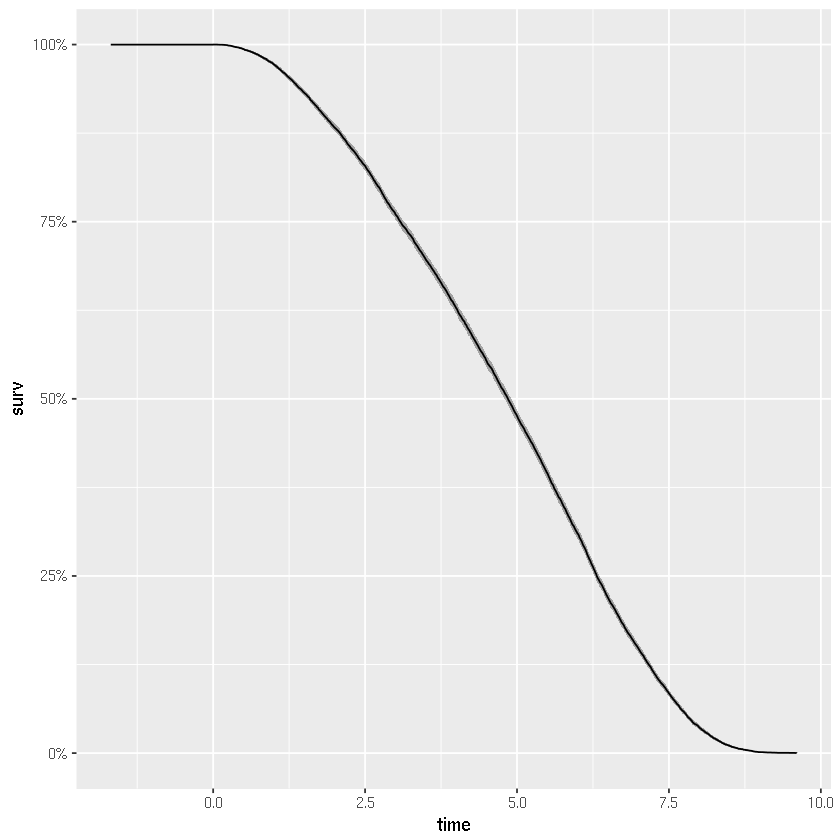

In [27]:
autoplot(cox2_fit)
